In [3]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [4]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [5]:
import evosax
import jax
import jax.numpy as jnp
from jax.random import split

In [6]:
import imageio

In [7]:
resize_fn = partial(jax.image.resize, shape=(64, 64, 3), method='nearest')

In [8]:
rng = jax.random.PRNGKey(0)

2024-08-12 08:52:20.434252: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(64, 64, 3) float32 1.0 0.011764706


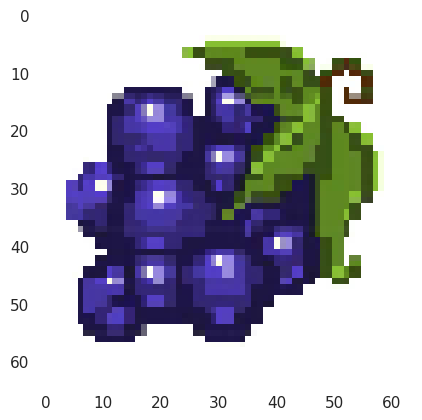

In [9]:
img = resize_fn(plt.imread("../img.jpg")/255.)
plt.imshow(img); plt.grid(False)
print(img.shape, img.dtype, img.max(), img.min())

In [10]:
from models_dnca import DNCA
import evosax
dnca = DNCA(grid_size=64, d_state=16, n_groups=8, identity_bias=0.2, temperature=0.1)

In [11]:

rng = jax.random.PRNGKey(0)
param_reshaper = evosax.ParameterReshaper(dnca.default_params(rng))
strategy = evosax.Sep_CMA_ES(popsize=16, num_dims=param_reshaper.total_params, sigma_init=0.1)
es_params = strategy.default_params

rng, _rng = split(rng)
es_state = strategy.initialize(_rng, es_params)



ParameterReshaper: 79505 parameters detected for optimization.


In [12]:
def calc_loss(rng, params, ret_img=False):
    def step(state, _rng):
        next_state = dnca.step_state(_rng, state, params)
        return next_state, state
    state_init = jnp.zeros((dnca.grid_size, dnca.grid_size, dnca.n_groups), dtype=int)
    state_init = state_init.at[dnca.grid_size//2, dnca.grid_size//2, :].set(1)
    # state_init = dnca.init_state(rng, params)

    state_final, state_vid = jax.lax.scan(step, state_init, split(rng, 128))
    img_dnca = dnca.render_state(state_final, params=params, img_size=64)
    loss = ((img_dnca - img)**2).mean()
    return (loss, img_dnca) if ret_img else (loss)
@jax.jit
def do_iter(es_state, rng):
    rng, _rng = split(rng)
    x, next_es_state = strategy.ask(_rng, es_state, es_params)
    params = param_reshaper.reshape(x)
    calc_loss_vv = jax.vmap(jax.vmap(calc_loss, in_axes=(0, None)), in_axes=(None, 0))
    rng, _rng = split(rng)
    loss = calc_loss_vv(split(_rng, 4), params)
    loss = loss.mean(axis=-1)
    next_es_state = strategy.tell(x, loss, next_es_state, es_params)
    return next_es_state, dict(best_loss=es_state.best_fitness, pop_loss=loss.mean())

  0%|          | 0/1000 [00:00<?, ?it/s]

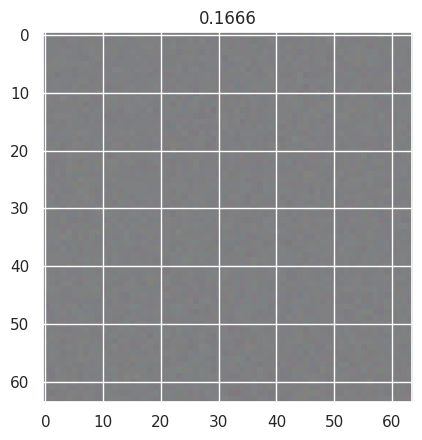

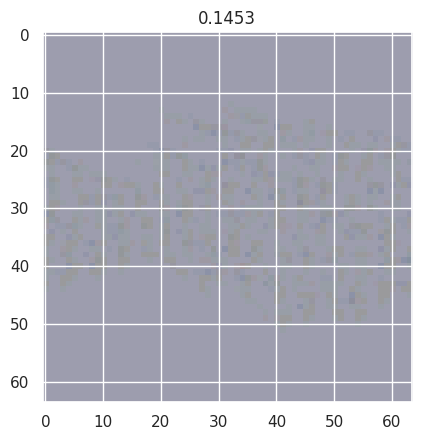

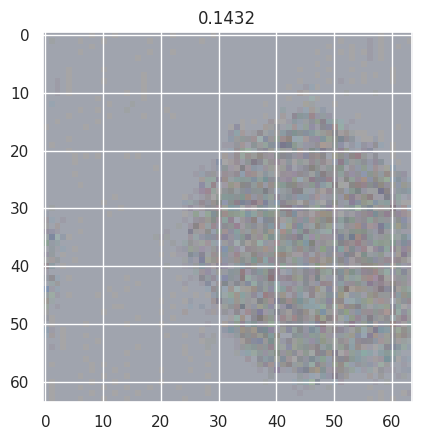

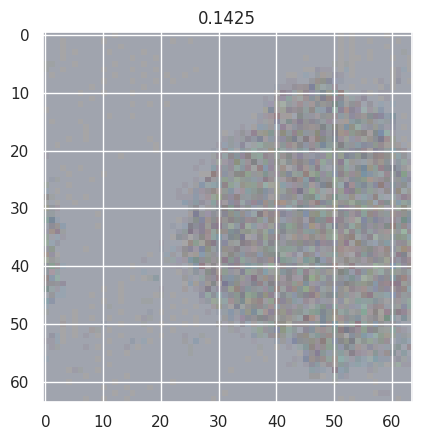

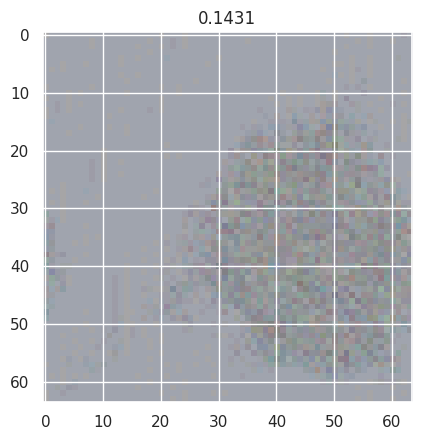

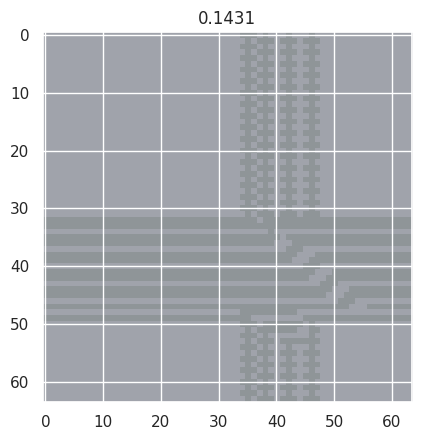

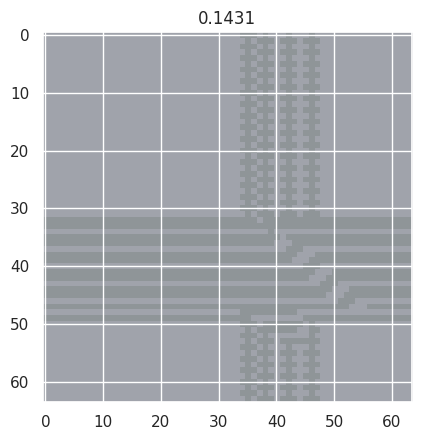

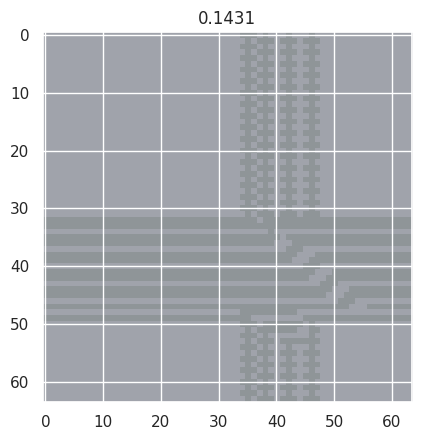

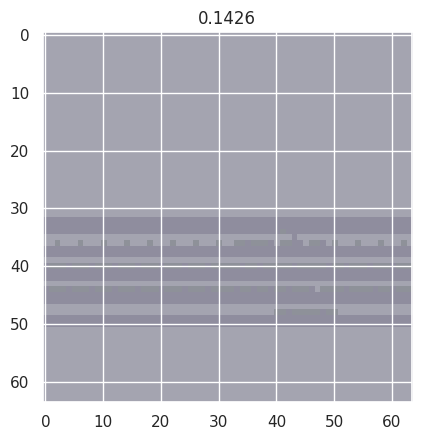

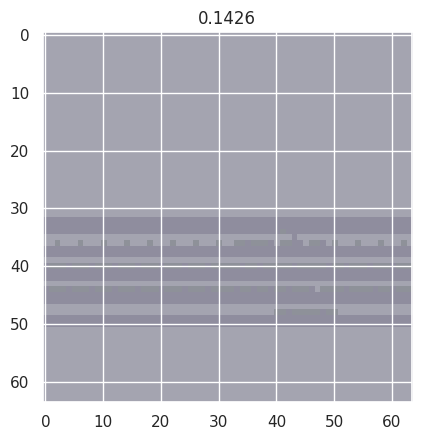

In [13]:
data = []
pbar = tqdm(range(1000))
for i_iter in pbar:
    rng, _rng = split(rng)
    es_state, di = do_iter(es_state, _rng)
    data.append(di)
    pbar.set_postfix(**di)

    if i_iter%100==0:
        loss, img_dnca = calc_loss(rng, param_reshaper.reshape_single(es_state.best_member), ret_img=True)
        plt.title(f"{loss.item():.4f}")
        plt.imshow(img_dnca)
        plt.show()

In [29]:
# imageio.mimwrite(f'./temp/vid.gif', np.array(vid), fps=30)